In [58]:
# Init library imports and repo path setup
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path

# add repo root (parent of notebooks/) to sys.path (use resolve for robustness)
repo_root = str(Path.cwd().resolve().parent)
if repo_root not in sys.path:
    sys.path.append(repo_root)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# Imports & basic config
from qiskit_ibm_runtime import QiskitRuntimeService
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from qiskit_aer import AerSimulator
from pathlib import Path
from tqdm import trange
import json
from lib.graphlib import GraphLib, run_on_ibm_runtime

service = QiskitRuntimeService(name="default-ibm-quantum-platform")

# Notebook defaults
AER_BACKEND = AerSimulator()
QAOA_SHOTS = 4096  # simulator shots for validating angles
EDGE_PROB = 0.3
WEIGHT_RANGE = (1, 20)
REPEATS = 5  # Repeats per size
PARTIAL_RESULT_PATH = Path(
    repo_root + "/data/maxcut_qaoa_partial_results.jsonl")

# Sweep sizes (you can change / expand)
MAX_SIZE_FOR_OPT = 20  # max n for which we compute optimal cuts via brute-force
MAX_SIZE_FOR_AER = 28  # max n for which we run the simulator (AER)
SIZE_RANGE = list(range(80, 150, 5))

# For plotting aesthetics
sns.set_theme(context="talk", style="whitegrid")

management.get:WARNING:2025-11-03 13:06:20,337: Loading saved account: default-ibm-quantum-platform


In [60]:
# Helper to run one graph instance and return results as dict
def run_qc_instance(g):
    available_backends = [b for b in service.backends(
    ) if b.configuration().n_qubits >= g.G.number_of_nodes() and b.status().operational]
    backend_name = sorted(available_backends,
                          key=lambda b: b.status().pending_jobs)[0].name
    # --- build graph and QAOA circuit
    t0 = time.time()
    gamma, beta, _, _ = g.optimize_qaoa1_classical(grid_res=41, refine=True)
    qc = g.build_qaoa1_circuit(gamma, beta)
    qc.measure_all()

    # --- run on hardware via IBM Runtime
    job = run_on_ibm_runtime(
        [qc], backend_name=backend_name, shots=QAOA_SHOTS, service=service)
    t1 = time.time()
    return job, t1-t0


def run_single_instance(n, run_qc, edge_prob=EDGE_PROB, weight_range=WEIGHT_RANGE, shots=QAOA_SHOTS):
    """
    Generate a random graph with n nodes and run:
      - classical approximations (random, local search)
      - qaoa p=1 analytic optimize + simulated validation (shots)
      - optional brute-force exact optimum if compute_optimal True
    Returns a dict with values and timings.
    """
    g = GraphLib()
    g.generate_random_graph(
        num_vertices=n, edge_prob=edge_prob, weight_range=weight_range)

    out = {'n': n, 'g': g}
    # Classical random approx
    t0 = time.time()
    _, w_rand = g.max_cut_random(trials=2000)
    t_rand = time.time() - t0
    out.update({'rand_cut': w_rand, 'rand_time': t_rand})

    # Classical local search approx
    t0 = time.time()
    _, w_local = g.max_cut_local_search(iterations=200)
    t_local = time.time() - t0
    out.update({'local_cut': w_local, 'local_time': t_local})

    # Brute force optimal if allowed for small n
    if n <= MAX_SIZE_FOR_OPT:
        t0 = time.time()
        _, w_opt = g.max_cut_bruteforce()
        t_opt = time.time() - t0
        out.update({'opt_cut': w_opt, 'opt_time': t_opt})
    else:
        out.update({'opt_cut': None, 'opt_time': None})
    # Reset remaining QAOA fields
    out.update({
        'qaoa_gamma': None, 'qaoa_beta': None,
        'qaoa_analytic_val': None, 'qaoa_opt_time': None,
        'qaoa_sampled_expectation': None, 'qaoa_best_cut': None,
        'qaoa_counts': None, 'qaoa_sim_time': None,
        'qaoa_total_time': None,
        'qaoa_shots': None,
        'qc_job': None, 'qc_prep_time': None,
        'qc_best_cut': None, 'qc_total_time': None
    })
    if (n <= MAX_SIZE_FOR_AER):
        # Simulator backend feasible only for small n
        # QAOA p=1: analytic optimization (fast)
        t0 = time.time()
        gamma_star, beta_star, val_star, _ = g.optimize_qaoa1_classical(
            grid_res=41, refine=True)
        t_qaoa_opt = time.time() - t0
        out.update({'qaoa_gamma': gamma_star, 'qaoa_beta': beta_star,
                    'qaoa_analytic_val': val_star, 'qaoa_opt_time': t_qaoa_opt})

        # Validate via simulator (shots)
        t0 = time.time()
        res = g.qaoa1_expectation_simulated(
            gamma_star, beta_star, shots=shots, backend=AER_BACKEND)
        t_qaoa_sim = time.time() - t0
        # res includes 'expectation' (sampled average), 'best_cut' (best sample)
        out.update({
            'qaoa_sampled_expectation': res['expectation'],
            'qaoa_best_cut': res['best_cut'],
            # 'qaoa_counts': res['counts'],  # Skip large array
            'qaoa_sim_time': t_qaoa_sim,
            'qaoa_total_time': t_qaoa_sim + t_qaoa_opt,
            'qaoa_shots': shots
        })
    if (run_qc):
        # Going to run the graph on real QC hardware
        job, timing = run_qc_instance(g)
        out.update({'qc_job': job, 'qc_prep_time': timing})
    return out

In [61]:
# Remove previous partial-results file so a full top-to-bottom run starts fresh
PARTIAL_RESULT_PATH.parent.mkdir(parents=True, exist_ok=True)
if PARTIAL_RESULT_PATH.exists():
    PARTIAL_RESULT_PATH.unlink()
    print(f"Removed existing partial results: {PARTIAL_RESULT_PATH}")
else:
    print(f"No partial results to remove at: {PARTIAL_RESULT_PATH}")

Removed existing partial results: C:\dev\qc-hello-worlds\data\maxcut_qaoa_partial_results.jsonl


In [62]:
# Sweep driver that runs multiple repeats per n and collects results
def sweep_ns(ns_list, repeats=REPEATS, partial_result_path=PARTIAL_RESULT_PATH):
    rows = []
    # Single outer progress bar over graph sizes; update its description to show current size & repeat
    outer = trange(len(ns_list), desc="n=")
    for idx in outer:
        n = ns_list[idx]
        for r in range(repeats):
            try:
                # Update outer progress bar description to show current graph size and repeat number
                outer.set_description(f"n={n} r={r+1}/{repeats}")
                # We run on real hardware with only one repeat to save on resources
                row = run_single_instance(
                    n, run_qc=(r == 0), edge_prob=EDGE_PROB, weight_range=WEIGHT_RANGE, shots=QAOA_SHOTS)
                row['repeat'] = r
                rows.append(row)
                # append to disk incrementally
                with partial_result_path.open("a") as f:
                    f.write(json.dumps(row, default=str) + "\n")
            except Exception as e:
                print(f"Instance failed for n={n}, repeat={r}: {e}")
    df = pd.DataFrame(rows)
    return df, rows


# Run the sweep (this will take time depending on NS_ALL and repeats)
df, rows = sweep_ns(SIZE_RANGE)
df.head()

n=145 r=5/5: 100%|██████████| 29/29 [36:37<00:00, 75.78s/it] 



n=145 r=5/5: 100%|██████████| 29/29 [36:37<00:00, 75.78s/it] 



,n,g,rand_cut,rand_time,local_cut,local_time,opt_cut,opt_time,qaoa_gamma,qaoa_beta,...,qaoa_best_cut,qaoa_counts,qaoa_sim_time,qaoa_total_time,qaoa_shots,qc_job,qc_prep_time,qc_best_cut,qc_total_time,repeat
0,5,<lib.graphlib.GraphLib object at 0x000002A12F6...,40,0.068176,17,0.000110,40.0,0.000928,0.955585,0.392705,...,40.0,None,0.282568,0.427458,4096.0,"<RuntimeJobV2('d44hipjen7ps73bhrepg', 'sampler')>",2.449345,None,None,0
1,5,<lib.graphlib.GraphLib object at 0x000002A1350...,51,0.045980,33,0.000082,51.0,0.000767,0.909674,0.392685,...,51.0,None,0.264114,0.409352,4096.0,None,NaN,None,None,1
2,5,<lib.graphlib.GraphLib object at 0x000002A1350...,44,0.108635,35,0.000089,44.0,0.000676,0.933203,0.392704,...,44.0,None,0.269235,0.408993,4096.0,None,NaN,None,None,2
3,5,<lib.graphlib.GraphLib object at 0x000002A1350...,36,0.104063,27,0.000062,36.0,0.000530,0.716007,0.317255,...,36.0,None,0.264967,0.425508,4096.0,None,NaN,None,None,3
4,5,<lib.graphlib.GraphLib object at 0x000002A1350...,59,0.105098,30,0.000082,59.0,0.000819,0.737129,0.353126,...,59.0,None,0.257107,0.424521,4096.0,None,NaN,None,None,4


In [63]:
# Wait for all real hardware jobs to complete and collect their results
for i, row in enumerate(rows):
    job = row['qc_job']
    if job is not None:
        print(f"Waiting for job {i} (n={row['n']}) to complete...")
        exec_span = job.result().metadata["execution"]["execution_spans"][0]
        qc_run_time = exec_span.stop - exec_span.start
        counts = job.result()[0].data.meas.get_counts()
        if counts:
            best_bitstring = max(counts, key=counts.get)
            best_cut = row['g'].cut_value_from_bitstring(best_bitstring)

            freqs = np.array(list(counts.values()), dtype=float)
            freqs = freqs / freqs.sum()
            print("\tunique:      ", len(counts))
            print("\tfrac ones:   ", sum(1 for v in counts.values() if v == 1) / len(counts))
            print("\tentropy bits:", entropy(freqs, base=2))
        else:
            best_cut = None
        # Update the row dict
        # row['qc_counts'] = counts  # huge array, skip storing
        row['qc_best_cut'] = best_cut
        row['qc_total_time'] = row['qc_prep_time'] + qc_run_time.total_seconds()
        # Update the DataFrame as well
        df.at[i, 'qc_total_time'] = row['qc_total_time']
        df.at[i, 'qc_best_cut'] = best_cut
    else:
        df.at[i, 'qc_best_cut'] = None
        df.at[i, 'qc_total_time'] = None

df.head()

Waiting for job 0 (n=5) to complete...
Waiting for job 5 (n=10) to complete...
Waiting for job 5 (n=10) to complete...
Waiting for job 10 (n=15) to complete...
Waiting for job 10 (n=15) to complete...
Waiting for job 15 (n=20) to complete...
Waiting for job 15 (n=20) to complete...
Waiting for job 20 (n=25) to complete...
Waiting for job 20 (n=25) to complete...
Waiting for job 25 (n=30) to complete...
Waiting for job 25 (n=30) to complete...
Waiting for job 30 (n=35) to complete...
Waiting for job 30 (n=35) to complete...
Waiting for job 35 (n=40) to complete...
Waiting for job 35 (n=40) to complete...
Waiting for job 40 (n=45) to complete...
Waiting for job 40 (n=45) to complete...
Waiting for job 45 (n=50) to complete...
Waiting for job 45 (n=50) to complete...
Waiting for job 50 (n=55) to complete...
Waiting for job 50 (n=55) to complete...
Waiting for job 55 (n=60) to complete...
Waiting for job 55 (n=60) to complete...
Waiting for job 60 (n=65) to complete...
Waiting for job 60 (

Waiting for job 0 (n=5) to complete...
Waiting for job 5 (n=10) to complete...
Waiting for job 5 (n=10) to complete...
Waiting for job 10 (n=15) to complete...
Waiting for job 10 (n=15) to complete...
Waiting for job 15 (n=20) to complete...
Waiting for job 15 (n=20) to complete...
Waiting for job 20 (n=25) to complete...
Waiting for job 20 (n=25) to complete...
Waiting for job 25 (n=30) to complete...
Waiting for job 25 (n=30) to complete...
Waiting for job 30 (n=35) to complete...
Waiting for job 30 (n=35) to complete...
Waiting for job 35 (n=40) to complete...
Waiting for job 35 (n=40) to complete...
Waiting for job 40 (n=45) to complete...
Waiting for job 40 (n=45) to complete...
Waiting for job 45 (n=50) to complete...
Waiting for job 45 (n=50) to complete...
Waiting for job 50 (n=55) to complete...
Waiting for job 50 (n=55) to complete...
Waiting for job 55 (n=60) to complete...
Waiting for job 55 (n=60) to complete...
Waiting for job 60 (n=65) to complete...
Waiting for job 60 (

,n,g,rand_cut,rand_time,local_cut,local_time,opt_cut,opt_time,qaoa_gamma,qaoa_beta,...,qaoa_best_cut,qaoa_counts,qaoa_sim_time,qaoa_total_time,qaoa_shots,qc_job,qc_prep_time,qc_best_cut,qc_total_time,repeat
0,5,<lib.graphlib.GraphLib object at 0x000002A12F6...,40,0.068176,17,0.000110,40.0,0.000928,0.955585,0.392705,...,40.0,None,0.282568,0.427458,4096.0,"<RuntimeJobV2('d44hipjen7ps73bhrepg', 'sampler')>",2.449345,9,4.483766,0
1,5,<lib.graphlib.GraphLib object at 0x000002A1350...,51,0.045980,33,0.000082,51.0,0.000767,0.909674,0.392685,...,51.0,None,0.264114,0.409352,4096.0,None,NaN,None,None,1
2,5,<lib.graphlib.GraphLib object at 0x000002A1350...,44,0.108635,35,0.000089,44.0,0.000676,0.933203,0.392704,...,44.0,None,0.269235,0.408993,4096.0,None,NaN,None,None,2
3,5,<lib.graphlib.GraphLib object at 0x000002A1350...,36,0.104063,27,0.000062,36.0,0.000530,0.716007,0.317255,...,36.0,None,0.264967,0.425508,4096.0,None,NaN,None,None,3
4,5,<lib.graphlib.GraphLib object at 0x000002A1350...,59,0.105098,30,0.000082,59.0,0.000819,0.737129,0.353126,...,59.0,None,0.257107,0.424521,4096.0,None,NaN,None,None,4


In [64]:
# Compute aggregated metrics per n and algorithm; compute aggregates
def compute_aggregates(df):
    # Ensure we have a count per group
    counts = df.groupby("n").size().rename("count").reset_index()
    # Use named aggregations for clarity
    agg = df.groupby("n").agg(
        opt_cut_mean=("opt_cut", "mean"),
        opt_cut_std=("opt_cut", "std"),
        rand_cut_mean=("rand_cut", "mean"),
        rand_cut_std=("rand_cut", "std"),
        local_cut_mean=("local_cut", "mean"),
        local_cut_std=("local_cut", "std"),
        qaoa_best_cut_mean=("qaoa_best_cut", "mean"),
        qaoa_best_cut_std=("qaoa_best_cut", "std"),
        qc_best_cut_mean=("qc_best_cut", "mean"),
        qc_best_cut_std=("qc_best_cut", "std"),
        rand_time_mean=("rand_time", "mean"),
        rand_time_std=("rand_time", "std"),
        local_time_mean=("local_time", "mean"),
        local_time_std=("local_time", "std"),
        qaoa_total_time_mean=("qaoa_total_time", "mean"),
        qaoa_total_time_std=("qaoa_total_time", "std"),
        qc_total_time_mean=("qc_total_time", "mean"),
        qc_total_time_std=("qc_total_time", "std"),
        opt_time_mean=("opt_time", "mean"),
        opt_time_std=("opt_time", "std"),
    ).reset_index()

    # attach counts and compute SEM using per-group counts
    agg = agg.merge(counts, on="n", how="left")

    for col_prefix in [
        "opt_cut",
        "rand_cut",
        "local_cut",
        "qaoa_best_cut",
        "qc_best_cut",
        "rand_time",
        "local_time",
        "qaoa_total_time",
        "qc_total_time",
        "opt_time",
    ]:
        std_col = f"{col_prefix}_std"
        sem_col = f"{col_prefix}_sem"
        # treat NaN std (e.g., single sample) as 0 so SEM becomes 0
        std_vals = agg[std_col].fillna(0)
        agg[sem_col] = std_vals / np.sqrt(agg["count"].replace(0, np.nan))

    return agg


agg_df = compute_aggregates(df)

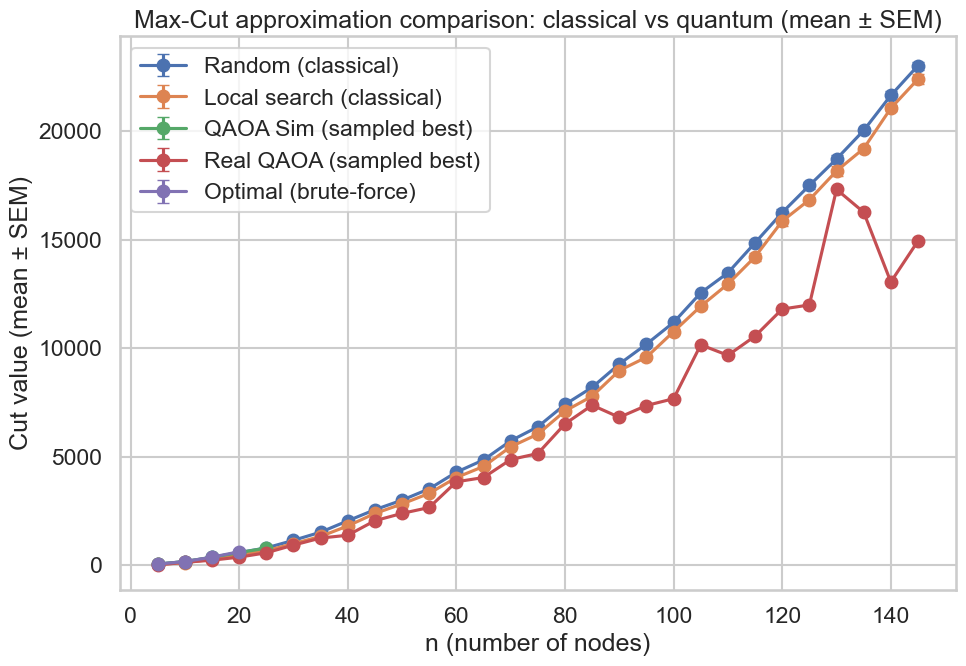

In [ ]:
# Cut value plots with error bars using precomputed std columns
def plot_cut_values(agg_df):
    plt.figure(figsize=(10, 7))

    def errplot(x, y, yerr, label, **kwargs):
        # Use a smaller marker size and thin edge for clarity
        plt.errorbar(x, y, yerr=yerr, fmt='-o', markersize=6, markeredgewidth=0.8,
                     capsize=4, label=label, **kwargs)

    errplot(agg_df['n'], agg_df['rand_cut_mean'],
            agg_df['rand_cut_sem'], 'Random (classical)')
    errplot(agg_df['n'], agg_df['local_cut_mean'],
            agg_df['local_cut_sem'], 'Local search (classical)')
    errplot(agg_df['n'], agg_df['qaoa_best_cut_mean'],
            agg_df['qaoa_best_cut_sem'], 'QAOA Sim (sampled best)')
    errplot(agg_df['n'], agg_df['qc_best_cut_mean'],
            agg_df['qc_best_cut_sem'], 'QAOA Real (sampled best)')
    if 'opt_cut_mean' in agg_df.columns and agg_df['opt_cut_mean'].notnull().any():
        errplot(agg_df['n'], agg_df['opt_cut_mean'],
                agg_df['opt_cut_sem'], 'Optimal (brute-force)')

    plt.xlabel('n (number of nodes)')
    plt.ylabel('Cut value (mean ± SEM)')
    plt.title('Max-Cut approximation comparison: classical vs quantum (mean ± SEM)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_cut_values(agg_df)

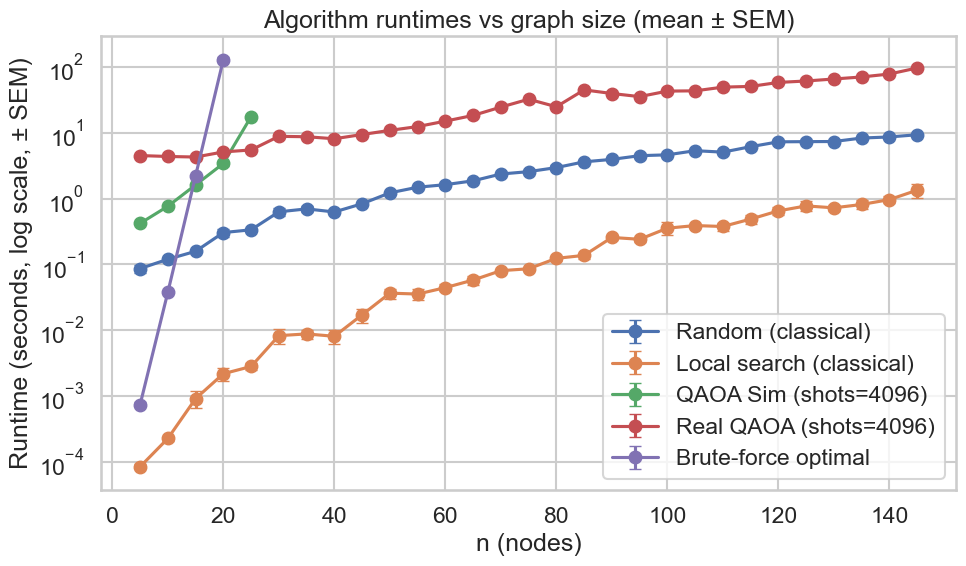

In [ ]:
# Runtime plots with error bars (log scale)
def plot_runtimes(agg_df):
    plt.figure(figsize=(10, 6))

    def errplot(x, ymean, yerr, label, **kwargs):
        # Use a smaller marker size and thin edge for clarity
        plt.errorbar(x, ymean, yerr=yerr, fmt='-o', markersize=6, markeredgewidth=0.8,
                     capsize=4, label=label, **kwargs)

    errplot(agg_df['n'], agg_df['rand_time_mean'],
            agg_df['rand_time_sem'], 'Random (classical)')
    errplot(agg_df['n'], agg_df['local_time_mean'],
            agg_df['local_time_sem'], 'Local search (classical)')
    errplot(agg_df['n'], agg_df['qaoa_total_time_mean'],
            agg_df['qaoa_total_time_sem'], f'QAOA Sim (shots={QAOA_SHOTS})')
    errplot(agg_df['n'], agg_df['qc_total_time_mean'],
            agg_df['qc_total_time_sem'], f'QAOA Real (shots={QAOA_SHOTS})')
    errplot(agg_df['n'], agg_df['opt_time_mean'],
            agg_df['opt_time_sem'], 'Brute-force optimal')

    plt.yscale('log')
    plt.xlabel('n (nodes)')
    plt.ylabel('Runtime (seconds, log scale, ± SEM)')
    plt.title('Algorithm runtimes vs graph size (mean ± SEM)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_runtimes(agg_df)

In [70]:
# Save raw and aggregated results (optional)
df.to_csv('../data/maxcut_qaoa_raw_results.csv', index=False)
agg_df.to_csv('../data/maxcut_qaoa_aggregates.csv', index=False)
print("Saved CSVs: raw and aggregates.")

Saved CSVs: raw and aggregates.
